# IMPORT SECTION

In [ ]:
!pip install --upgrade music21
from music21 import converter, instrument, note, chord
import os
from tqdm import tqdm
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout
%load_ext tensorboard 
from tensorboard import notebook
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

     |████████████████████████████████| 19.3MB 1.3MB/s 
  Created wheel for music21: filename=music21-6.7.1-cp37-none-any.whl size=21941694 sha256=8f7459ec354a994ee218d1b8677dc3698daeb481af48a2b1ce2b0e6c4e0f3af9
  Stored in directory: /root/.cache/pip/wheels/1a/0f/0e/f78ad56a2738f4ea5082dd4283d7b7cce18a8ba20c3e609b6c
Successfully built music21
  Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0


In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=False)

MIDI_PATH="/content/drive/My Drive/MLFolder/Onlab/MIDI_Iron_Maiden/"

Mounted at /content/drive


In [ ]:
!nvidia-smi

Mon Mar 15 16:26:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# UTILITY FUNCTIONS SECTION

In [ ]:
#https://www.geeksforgeeks.org/python-find-most-frequent-element-in-a-list/

def most_frequent(paramlist): 
    counter = 0
    num = paramlist[0] 
      
    for i in paramlist: 
        curr_frequency = paramlist.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
  
    return num 

#Utility functions

def get_notes_from_chord(chord):
    if chord.startswith("<music21.chord.Chord "):
        chord = chord[len("<music21.chord.Chord "):]
    if chord.endswith(">"):
        chord = chord[:-1]
    chord = chord.replace(" ", ",")
    return chord

def get_number_from_duration(duration):
    if duration.startswith("<music21.duration.Duration "):
        duration = duration[len("<music21.duration.Duration "):]
    if duration.endswith(">"):
        duration = duration[:-1]
    duration = duration.replace(" ", ",")
    return duration

def create_mapper(chords):
    pitchnames = sorted(set(str(item) for item in chords))
    mapper = dict((note, number) for number, note in enumerate(pitchnames))

    return mapper

def encode_using_mapper(chords, mapper):
    encodedsong=[]
    for c in chords:
        encodedsong.append(mapper[str(c)])

    return encodedsong


def decode_chords_using_mapper(numbers, mapper):
    outputnotes = []
    for number in numbers:
        outputnotes.append(chord_from_string(get_notes_from_chord(get_key_from_value(number, mapper))))

    return outputnotes

def combine_chords_with_durations(chords, durations):
    combined = []

    for i, j in zip(chords, durations):
        i = get_notes_from_chord(str(i))
        j = get_number_from_duration(str(j))
        combined.append(i + ';' + j)

    return combined

def make_slices(data, slice_length):
    for song in tqdm(data):
        if len(song) > slice_length:

            input = []
            output = []
            slice = []

            for idx, number in enumerate(song):
                if idx < slice_length:
                    slice.append(number)

            input.append(slice.copy())
            output.append(song[slice_length])

            # Sliding window
            for idx, number in enumerate(song):
                if idx >= slice_length and (idx + 1) < len(song):
                    slice.pop(0)
                    slice.append(number)
                    input.append(slice.copy())  # Copy is necessary, because of how pointers and lists work in Python
                    output.append(song[idx + 1])

    return input, output

def parse_everything_together(data, slice_length):

    notes=[]
    input=[]
    output=[]
    slice = []

    for song in tqdm(data):
        for number in song:
            notes.append(number)
    
    for idx, note in tqdm(enumerate(notes)):
        if idx < slice_length:
            slice.append(number)

    input.append(slice.copy())
    output.append(notes[slice_length])

    # Sliding window
    for idx, number in tqdm(enumerate(notes)):
        if idx >= slice_length and (idx + 1) < len(notes):
            slice.pop(0)
            slice.append(number)
            input.append(slice.copy())  # Copy is necessary, because of how pointers and lists work in Python
            output.append(notes[idx + 1])
        
    return input, output

def get_key_from_value(value, dict):
    return list(dict.keys())[list(dict.values()).index(value)]

def get_notes_from_chord(chord):
    if chord.startswith("<music21.chord.Chord "):
        chord = chord[len("<music21.chord.Chord "):]
    if chord.endswith(">"):
        chord = chord[:-1]
    chord = chord.replace(" ", ",")
    return chord

def get_number_from_duration(duration):
    if duration.startswith("<music21.duration.Duration "):
        duration = duration[len("<music21.duration.Duration "):]
    if duration.endswith(">"):
        duration = duration[:-1]
    duration = duration.replace(" ", ",")
    return duration

def chord_from_string(chordstring):
    notes = chordstring.split(";")
    return chord.Chord(notes)

#From: https://stackoverflow.com/questions/1806278/convert-fraction-to-float
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

#Source: https://github.com/alexissa32/DataScienceMusic
def create_midi_without_chords(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    '''
    First step:
    Only notes, no chords
    Static 4/4 beat
    Rests
    '''
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a rest
        if('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def create_midi_without_durations(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    '''
    Second step:
    Chords and notes
    Static 4/4 beat
    Rests
    '''
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('chord' in pattern):
            notes = []
            pattern = get_notes_from_chord(pattern)
            patternpitches = pattern.split(',')
            for current_note in patternpitches:
                new_note = note.Note(current_note)
                new_note.storedInstrument = target_instrument
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def create_midi_with_durations(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for i in range(len(prediction_output)):
        pattern = prediction_output[i]
        splitpattern = pattern.split(";")
        pattern = splitpattern[0]

        duration = get_number_from_duration(splitpattern[1])
        # pattern is a chord
        if ('chord' in pattern):
            notes = []
            pattern = get_notes_from_chord(pattern)
            patternpitches = pattern.split(',')
            for current_note in patternpitches:
                new_note = note.Note(current_note)
                new_note.storedInstrument = target_instrument
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += convert_to_float(duration)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def create_midi_with_embedded_durations(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for i in range(len(prediction_output)):
        pattern = prediction_output[i]
        splitpattern = pattern.split(";")
        pattern = splitpattern[0]

        duration = get_number_from_duration(splitpattern[1])
        # pattern is a rest
        if('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a chord
        elif (',' in pattern):
            notes = []
            pattern = get_notes_from_chord(pattern)
            patternpitches = pattern.split(',')
            for current_note in patternpitches:
                new_note = note.Note(current_note)
                new_note.storedInstrument = target_instrument
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += convert_to_float(duration)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

In [ ]:
def preprocess_data_without_chords():
    #Akkordok nélkül, restekkel
    midiparts = []

    for file in tqdm(os.listdir(path)):
        midi = converter.parse(os.path.join(path, file))

        for part in midi.parts:
            notes=[]
            durations=[]
            for element in part.notesAndRests:
                if isinstance(element, note.Note):
                    notes.append(element.pitch)
                    durations.append(element.duration)
                elif isinstance(element, chord.Chord):
                    notes.append(element.root())
                    durations.append(element.duration)
                elif isinstance(element, note.Rest):
                    notes.append(element)
                    durations.append(element.duration)

            if len(notes) > 0:
                midiparts.append(MidiPart(file, part.partName, notes, durations))
            else:
                for voice in part.voices:
                    notes=[]
                    durations=[]
                    for element in voice.notesAndRests:
                        if isinstance(element, note.Note):
                            notes.append(element.pitch)
                            durations.append(element.duration)
                        elif isinstance(element, chord.Chord):
                            notes.append(element.root())
                            durations.append(element.duration)
                        elif isinstance(element, note.Rest):
                            notes.append(element)
                            durations.append(element.duration)

                    midiparts.append(MidiPart(file, part.partName, notes, durations))
    
    return midiparts

def preprocess_data_without_chords_and_rests():
    #Restek nélkül, akkordok nélkül
    midiparts = []

    for file in tqdm(os.listdir(path), position=0, leave=True):
        midi = converter.parse(os.path.join(path, file))

        for part in midi.parts:
            for voice in part.voices:
                notes=[]
                durations=[]
                for element in voice.notes: 
                    if isinstance(element, note.Note):
                        notes.append(element.pitch)
                        durations.append(element.duration)
                    elif isinstance(element, chord.Chord):
                        notes.append(element.root())
                        durations.append(element.duration)
                    elif isinstance(element, note.Rest):
                        notes.append(element)
                        durations.append(element.duration)

                midiparts.append(MidiPart(file, part.partName, notes, durations))

    return midiparts

# PREPROCESSING SECTION

In [ ]:
class MidiPart:
    def __init__(self, song, instrument, chords, durations):
        self.song = song
        self.instrument = instrument
        self.chords = chords
        self.durations = durations


path = MIDI_PATH

IRON_MAIDEN_INSTRUMENTS = ['Acoustic Guitar', 'Viola', 'Electric Bass', 'Brass', 'Sampler', 'Electric Guitar', 'Piano', 'StringInstrument']

TARGET_INSTRUMENT = 'Electric Guitar'

SLICE_LEN = 20




In [ ]:
midiparts = []

for file in tqdm(os.listdir(path)):
    midi = converter.parse(os.path.join(path, file))

    for part in midi.parts:
        chords=[]
        durations=[]
        for element in part.notesAndRests:
            if isinstance(element, note.Note):
                chords.append(chord.Chord([element]))
                durations.append(element.duration)
            elif isinstance(element, chord.Chord):
                chords.append(element)
                durations.append(element.duration)
            elif isinstance(element, note.Rest):
                chords.append(element)
                durations.append(element.duration)

        if len(chords) > 0:
            midiparts.append(MidiPart(file, part.partName, chords, durations))
        else:
            for voice in part.voices:
                chords=[]
                durations=[]
                for element in voice.notesAndRests:
                    if isinstance(element, note.Note):
                        chords.append(chord.Chord([element]))
                        durations.append(element.duration)
                    elif isinstance(element, chord.Chord):
                        chords.append(element)
                        durations.append(element.duration)
                    elif isinstance(element, note.Rest):
                        chords.append(element)
                        durations.append(element.duration)

                midiparts.append(MidiPart(file, part.partName, chords, durations))

100%|██████████| 93/93 [13:33<00:00,  8.75s/it]


In [ ]:
allchords = []
alldurations = []

#TARGET_INSTRUMENT = 'Electric Bass'
for i in midiparts:
    if i.instrument == TARGET_INSTRUMENT:
        if len(i.chords)>0 :
            allchords.append(i.chords)
            alldurations.append(i.durations)

In [ ]:
#I create the Note/Chord/Rest to Number mapper here.

mapperdata = []
durationmapperdata = []

for i in allchords:
    for j in i:
        mapperdata.append(j)

for i in alldurations:
    for j in i:
        durationmapperdata.append(j)

mapper = create_mapper(mapperdata)
durationmapper = create_mapper(durationmapperdata)

In [ ]:
#I ensure that the dimensions are right
assert(len(allchords)==len(alldurations))
for i in range(len(allchords)):
    assert(len(allchords[i])==len(alldurations[i]))

In [ ]:
#I encode the data here using the mapper.

encoded_data = []
encoded_durations = []

for i in range(len(allchords)):
    encoded = encode_using_mapper(allchords[i], mapper)
    encoded_data.append(encoded)
    encoded_dur = encode_using_mapper(alldurations[i], durationmapper)
    encoded_durations.append(encoded_dur)

assert(len(encoded_data)==len(encoded_durations))

In [ ]:
#I filter out those chord sequences, which are majorly rests. I do this because I don't want the network to make a song, which contains nothing, but rests. Our dataset has about 100 guitar tracks, which contain rests for the majority of the track, and a guitar solo near the end.
#An upgrade for this could be that I don't just delete those tracks from the dataset, but only filter out the rests, and leave the guitar solo in.


restkeysvalues = []
for j in mapper.keys():
    if ( 'rest' in j):
        restkeysvalues.append(mapper[j])

cleared_encoded_data=[]
cleared_encoded_durations=[]


for i in range(len(encoded_data)):
    if most_frequent(encoded_data[i]) not in restkeysvalues:
        cleared_encoded_data.append(encoded_data[i])
        cleared_encoded_durations.append(encoded_durations[i])
    else:
        pass

In [ ]:
note_input, note_output = parse_everything_together(cleared_encoded_data, SLICE_LEN)
dur_input, dur_output = parse_everything_together(cleared_encoded_durations, SLICE_LEN)

100%|██████████| 348/348 [00:00<00:00, 21722.44it/s]
225249it [00:00, 3228060.02it/s]
225249it [00:00, 882271.49it/s]
100%|██████████| 348/348 [00:00<00:00, 24088.88it/s]
225249it [00:00, 3194971.92it/s]
225249it [00:00, 918151.98it/s]


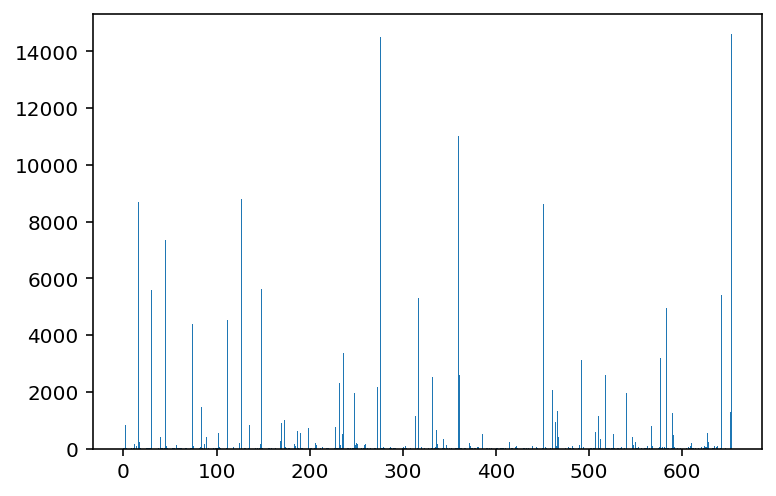

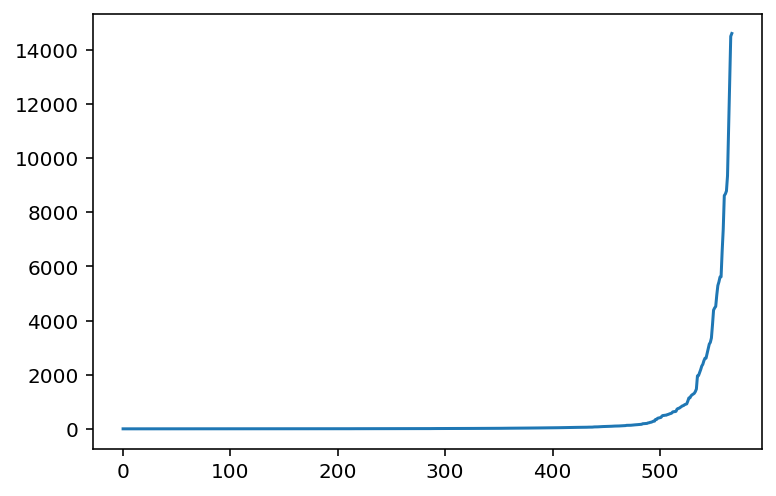

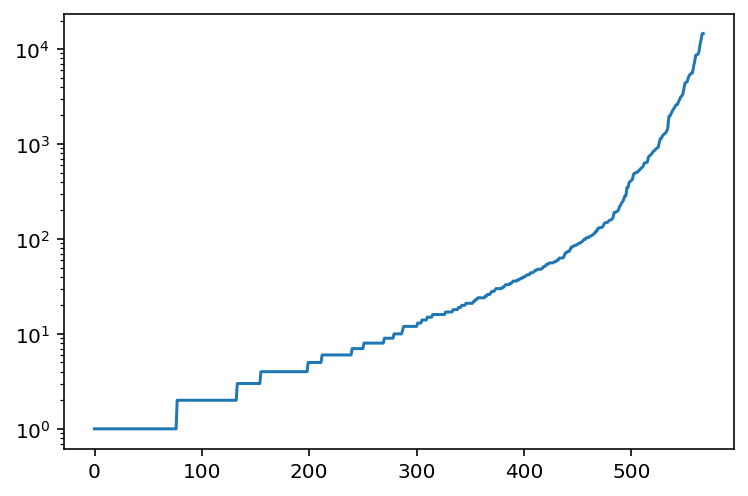

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

note_outputcnt = Counter(note_output)
plt.bar(note_outputcnt.keys(), note_outputcnt.values())
plt.show()

function_like_array=[]
for val in note_outputcnt.values():
    function_like_array.append(val)

function_like_array.sort()
plt.plot(function_like_array)
plt.show()
#Plot it on log scale as well
plt.yscale('log')
plt.plot(function_like_array)
plt.show()

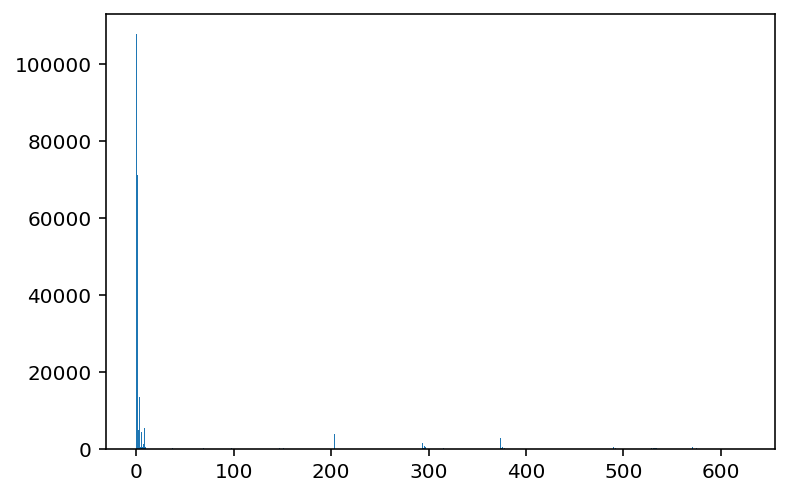

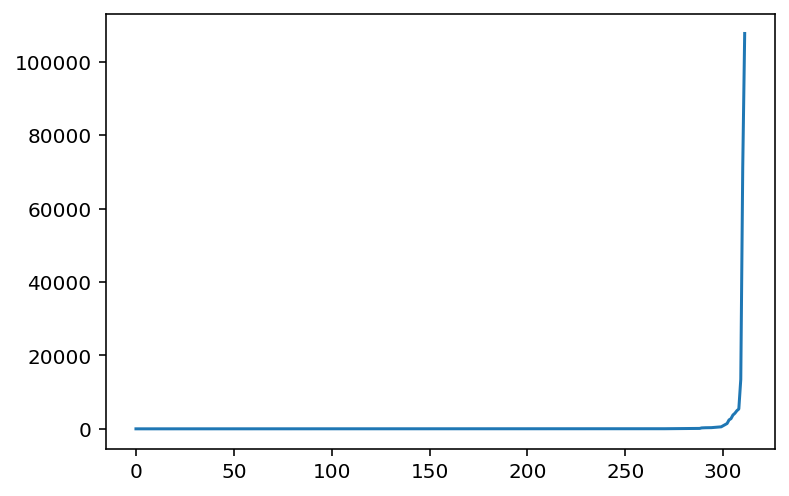

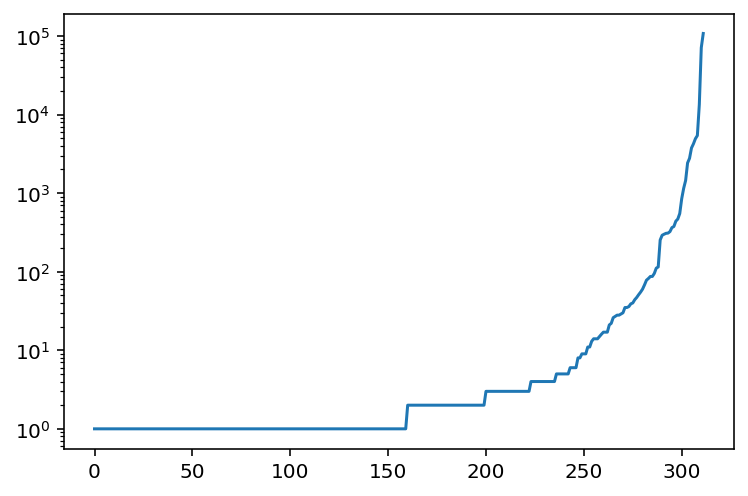

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

dur_outputcnt = Counter(dur_output)
plt.bar(dur_outputcnt.keys(), dur_outputcnt.values())
plt.show()

function_like_array=[]
for val in dur_outputcnt.values():
    function_like_array.append(val)

function_like_array.sort()
plt.plot(function_like_array)
plt.show()
#Plot it on log scale as well
plt.yscale('log')
plt.plot(function_like_array)
plt.show()

In [ ]:
note_outliers = []
dur_outliers = []

for i in note_outputcnt.keys():
    if note_outputcnt[i] < 5:
        note_outliers.append(i)

for i in dur_outputcnt.keys():
    if dur_outputcnt[i] < 5:
        dur_outliers.append(i)

print(len(note_outliers))
print(len(dur_outliers))

199
236


In [ ]:
#Because I don't want to mess up my inputs and outputs, I test their lengths before and after the outlier filtering.
assert(len(note_input) == len(note_output) == len(dur_input) == len(dur_output))

new_note_input = []
new_note_output = []
new_duration_input = []
new_duration_output = []

for i in range(len(note_output)):
    if(note_output[i] not in note_outliers) and (dur_output[i] not in dur_outliers):
        new_note_input.append(note_input[i])
        new_note_output.append(note_output[i])
        new_duration_input.append(dur_input[i])
        new_duration_output.append(dur_output[i])

note_input = new_note_input
note_output = new_note_output
dur_input = new_duration_input
dur_output = new_duration_output

assert(len(note_input) == len(note_output) == len(dur_input) == len(dur_output))

In [ ]:
#However, this outlier filtering made things complicated. Now I have to make a new mapper, so that i won't end up with output classes containing 0 elements.

note_mapper_list = [] #Idx of the mapper list is the new value, the element is the old value.
dur_mapper_list = []
new_note_output_elements = set(note_output)
new_dur_output_elements = set(dur_output)

for i in new_note_output_elements:
    note_mapper_list.append(i)

for i in new_dur_output_elements:
    dur_mapper_list.append(i)

new_note_output = []
new_dur_output = []

for i in note_output:
    new_note_output.append(note_mapper_list.index(i))

for i in dur_output:
    new_dur_output.append(dur_mapper_list.index(i))

note_output = new_note_output
dur_output = new_dur_output

In [ ]:
#Reshaping the input data to be compatible with LSTMs and normalizing it in the hope of better learning.

note_input = np.reshape(np.asarray(note_input), (len(note_input), SLICE_LEN, 1))
note_output = to_categorical(note_output)

note_input=np.asarray(note_input) / float(len(mapper))
note_output=np.asarray(note_output)


dur_input = np.reshape(np.asarray(dur_input), (len(dur_input), SLICE_LEN, 1))
dur_output = to_categorical(dur_output)

dur_input=np.asarray(dur_input) / float(len(durationmapper))
dur_output=np.asarray(dur_output)


In [ ]:
#TRAIN_VAL_TEST_SPLIT

SEED = 54
np.random.seed(SEED)

from sklearn.model_selection import train_test_split

note_X_train, note_X_test, note_Y_train, note_Y_test = train_test_split(note_input, note_output, test_size=0.01, random_state=SEED)
note_X_train, note_X_val, note_Y_train, note_Y_val = train_test_split(note_X_train, note_Y_train, test_size=0.2, random_state=SEED)

duration_X_train, duration_X_test, duration_Y_train, duration_Y_test = train_test_split(dur_input, dur_output, test_size=0.01, random_state=SEED)
duration_X_train, duration_X_val, duration_Y_train, duration_Y_val = train_test_split(duration_X_train, duration_Y_train, test_size=0.2, random_state=SEED)

startidx = np.random.randint(0, len(note_X_test)-1)

starting_slice_notes = note_X_test[startidx]
starting_slice_durations = duration_X_test[startidx]

print(note_X_train.shape, note_X_val.shape, note_X_test.shape, note_Y_train.shape, note_Y_val.shape, note_Y_test.shape)
print(duration_X_train.shape, duration_X_val.shape, duration_X_test.shape, duration_Y_train.shape, duration_Y_val.shape, duration_Y_test.shape)
print(startidx)
print(starting_slice_notes)
print(starting_slice_durations)

(177754, 20, 1) (44439, 20, 1) (2245, 20, 1) (177754, 369) (44439, 369) (2245, 369)
(177754, 20, 1) (44439, 20, 1) (2245, 20, 1) (177754, 76) (44439, 76) (2245, 76)
898
[[0.55198777]
 [0.02446483]
 [0.99847095]
 [0.02446483]
 [0.02446483]
 [0.02446483]
 [0.99847095]
 [0.02446483]
 [0.02446483]
 [0.02446483]
 [0.89143731]
 [0.02446483]
 [0.99847095]
 [0.02446483]
 [0.02446483]
 [0.02446483]
 [0.99847095]
 [0.02446483]
 [0.02446483]
 [0.02446483]]
[[0.0048]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.0032]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]]


# MODEL TRAINING SECTION

In [ ]:
MODEL_NAME = "multioutputoutlierfilteredguitarmodel3"

MODEL_SAVE_PATH = "/content/drive/MyDrive/MLFolder/Onlab/modelsaves"

TBPATH = "/content/tblogs/"+MODEL_NAME

In [ ]:
#Before creating the neural network, I define some important callbacks

tb = TensorBoard(log_dir = TBPATH, write_images=True, histogram_freq=1)

plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00005, verbose=1)

es = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True, verbose=1)

callbacks = [plateau, es, tb]

In [ ]:
#I create the neural network model here.
from keras.layers import Input
from keras import Model
from keras.layers import Concatenate, Multiply, Add, Dot, MultiHeadAttention

notes_input = Input(shape=(note_X_train.shape[1], note_X_train.shape[2]), name="notes_in")
durations_input = Input(shape=(duration_X_train.shape[1], duration_X_train.shape[2]), name="durations_in")

x=LSTM(512, return_sequences=True)(notes_input)
x=LSTM(256, return_sequences=True)(x)
x=LSTM(32, return_sequences=True)(x)

y=LSTM(64, return_sequences=True)(durations_input)
y=LSTM(32, return_sequences=True)(y)

together = MultiHeadAttention(num_heads=2, key_dim=2)(x, y)
together = MultiHeadAttention(num_heads=2, key_dim=2)(together, together)
together = MultiHeadAttention(num_heads=2, key_dim=2)(together, together)
together = LSTM(64)(together)
#together = Dense(64, activation='relu')(together)
#together = LSTM(32)(together)
#together = Dense(64, activation='relu')(together)
#together = Flatten()(together)
#together = Dense(64, activation = 'relu')(together)

notes_predictor = Dense(note_Y_train.shape[1], activation='softmax', name='notes_out')(together)
durations_predictor = Dense(duration_Y_train.shape[1], activation='softmax', name='durations_out')(together)

model = Model(
    inputs=[notes_input, durations_input],
    outputs=[notes_predictor, durations_predictor]
)

#model = Sequential()
#model.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
#model.add(LSTM(256))
#model.add(Dense(Y_train.shape[1], activation='softmax'))


model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'], loss_weights=[1.3, 0.7])

model.fit({"notes_in" : note_X_train, "durations_in" : duration_X_train}, 
          {"notes_out" : note_Y_train, "durations_out" : duration_Y_train},
          epochs=10000, batch_size=16,
          validation_data=({"notes_in" : note_X_val, "durations_in" : duration_X_val},
                           {"notes_out" : note_Y_val, "durations_out" : duration_Y_val}),
           callbacks=callbacks)

#model.evaluate(X_test, Y_test)

model.save(MODEL_SAVE_PATH + MODEL_NAME + ".h5")

Epoch 1/10000
11110/11110 [==============================] - 195s 17ms/step - loss: 6.3836 - notes_out_loss: 4.0908 - durations_out_loss: 1.5221 - notes_out_accuracy: 0.0666 - durations_out_accuracy: 0.4904 - val_loss: 6.0216 - val_notes_out_loss: 3.9745 - val_durations_out_loss: 1.2210 - val_notes_out_accuracy: 0.0754 - val_durations_out_accuracy: 0.6084
Epoch 2/10000
11110/11110 [==============================] - 185s 17ms/step - loss: 6.0241 - notes_out_loss: 3.9676 - durations_out_loss: 1.2374 - notes_out_accuracy: 0.0778 - durations_out_accuracy: 0.6011 - val_loss: 5.8368 - val_notes_out_loss: 3.9014 - val_durations_out_loss: 1.0927 - val_notes_out_accuracy: 0.0844 - val_durations_out_accuracy: 0.6772
Epoch 3/10000
11110/11110 [==============================] - 185s 17ms/step - loss: 5.8011 - notes_out_loss: 3.8721 - durations_out_loss: 1.0963 - notes_out_accuracy: 0.0899 - durations_out_accuracy: 0.6711 - val_loss: 5.6726 - val_notes_out_loss: 3.7997 - val_durations_out_loss: 1.0

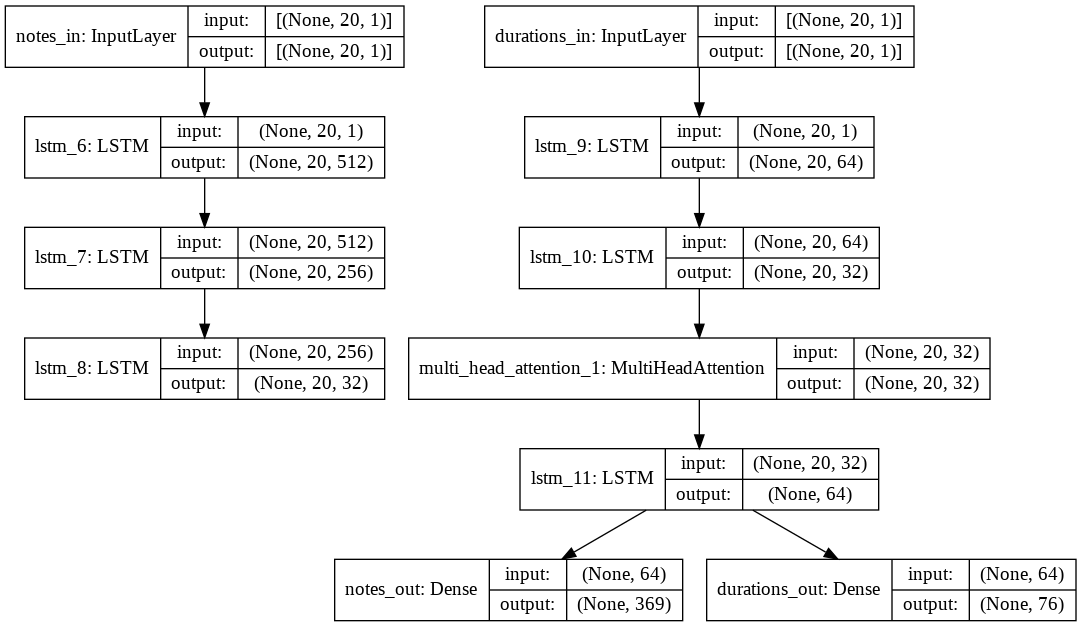

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
notes_in (InputLayer)           [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
durations_in (InputLayer)       [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 20, 512)      1052672     notes_in[0][0]                   
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 20, 64)       16896       durations_in[0][0]               
____________________________________________________________________________________________

In [ ]:
model.fit(X_train, Y_train, epochs=10000, batch_size=16, validation_data=(X_val, Y_val), callbacks=callbacks)

model.evaluate(X_test, Y_test)

model.save(MODEL_SAVE_PATH + MODEL_NAME + ".h5")

In [ ]:
#model.evaluate(X_test, Y_test)

model.save(MODEL_SAVE_PATH + MODEL_NAME + ".h5")

In [ ]:
model.predict({"notes_in" : note_X_train[0], "durations_in" : duration_X_train[0]})

[array([[6.8481938e-08, 3.7634980e-09, 4.1670230e-08, ..., 1.4625159e-02,
         2.5358373e-09, 1.5699650e-04],
        [6.8481938e-08, 3.7634980e-09, 4.1670230e-08, ..., 1.4625159e-02,
         2.5358373e-09, 1.5699650e-04],
        [6.8481938e-08, 3.7634980e-09, 4.1670230e-08, ..., 1.4625159e-02,
         2.5358373e-09, 1.5699650e-04],
        ...,
        [7.9962819e-09, 1.3586098e-10, 1.0117931e-08, ..., 4.8690685e-03,
         5.3372873e-10, 2.3449662e-03],
        [7.9962819e-09, 1.3586098e-10, 1.0117931e-08, ..., 4.8690685e-03,
         5.3372873e-10, 2.3449662e-03],
        [5.4955289e-09, 2.2133194e-10, 8.4906027e-11, ..., 2.8537661e-05,
         5.2916303e-11, 4.1752704e-03]], dtype=float32),
 array([[4.3554444e-02, 1.4003227e-02, 1.2378247e-02, ..., 2.3589220e-02,
         1.4186692e-02, 2.5390997e-03],
        [4.3554444e-02, 1.4003227e-02, 1.2378247e-02, ..., 2.3589220e-02,
         1.4186692e-02, 2.5390997e-03],
        [4.3554444e-02, 1.4003227e-02, 1.2378247e-02, ...,

In [ ]:
#I use the TensorBoard here

%tensorboard --logdir="/content/tblogs/bassmodelwithmultioutputs5" #TODO FIX THIS TO BE A VARIABLE

# INFERENCE AND POSTPROCESSING SECTION

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    preds = np.squeeze(preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
def generate_notes(model, starting_slice, starting_duration, mapper, mapperlist = None, temp=1.0, duration_temp=0.8):
    """ Generate notes from the neural network based on a sequence of notes """
    pattern = starting_slice
    duration_pattern = starting_duration
    prediction_output_notes = []
    prediction_output_durations = []
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_duration_input = np.reshape(duration_pattern, (1, len(duration_pattern), 1))

        note_prediction, duration_prediction = model.predict({"notes_in" : prediction_input, "durations_in" : prediction_duration_input})

        #prediction = sample(prediction, temp)
        index = sample(note_prediction, temp)
        duration_index = sample(duration_prediction, duration_temp)

        #index = np.argmax(prediction)
        if mapperlist is not None: #Idx of the mapper list is the new value, the element is the old value. This is used when I filter for outliers.
            index=mapperlist[index]

        result = get_key_from_value(index, mapper)
        prediction_output_notes.append(result)

        duration_result = get_key_from_value(duration_index, durationmapper)
        prediction_output_durations.append(duration_result)

        pattern = np.append(pattern, index/float(len(mapper)))
        duration_pattern = np.append(duration_pattern, duration_index/float(len(durationmapper)))

        pattern = pattern[1:len(pattern)]
        duration_pattern = duration_pattern[1:len(duration_pattern)]

    for i in range(len(prediction_output_notes)):
        prediction_output.append(str(prediction_output_notes[i]) + ';' + str(prediction_output_durations[i]))

    return prediction_output

In [ ]:
generated_outputs=[]

temperatures = [0.5, 0.7, 0.8, 0.9, 1.0, 1.2]

# DO NOT FORGET, IMPORTANT: When using outlier filtering, DO NOT FORGET to use the mapperlist parameter!!

for temp in tqdm(temperatures):
    generated_outputs.append(generate_notes(model, starting_slice_notes, starting_slice_durations, mapper, None, temp = temp, duration_temp=0.8))

 17%|█▋        | 1/6 [00:18<01:30, 18.14s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
100%|██████████| 6/6 [01:49<00:00, 18.30s/it]


In [ ]:
for out in generated_outputs:
    print(out)

['<music21.chord.Chord A4>;<music21.duration.Duration 0.5>', '<music21.chord.Chord G4>;<music21.duration.Duration 0.5>', '<music21.chord.Chord E4>;<music21.duration.Duration 1.5>', '<music21.chord.Chord G4>;<music21.duration.Duration 0.5>', '<music21.chord.Chord G4>;<music21.duration.Duration 0.5>', '<music21.chord.Chord G4>;<music21.duration.Duration 0.5>', '<music21.chord.Chord G4>;<music21.duration.Duration 0.5>', '<music21.chord.Chord G4>;<music21.duration.Duration 0.5>', '<music21.chord.Chord D5>;<music21.duration.Duration 3.0>', '<music21.note.Rest rest>;<music21.duration.Duration 1/12>', '<music21.chord.Chord D5>;<music21.duration.Duration 1.0>', '<music21.chord.Chord B4>;<music21.duration.Duration 0.5>', '<music21.chord.Chord B4>;<music21.duration.Duration 3.0>', '<music21.chord.Chord B4>;<music21.duration.Duration 1.0>', '<music21.chord.Chord A4>;<music21.duration.Duration 0.5>', '<music21.chord.Chord A4>;<music21.duration.Duration 0.5>', '<music21.chord.Chord A4>;<music21.dur

In [ ]:
from music21 import stream

STARTING_OFFSET = 0

OUTPUT_PATH = "/content/drive/MyDrive/MLFolder/Onlab/Outputs/"

for i, out in enumerate(generated_outputs):
    create_midi_with_durations(out, target_instrument = instrument.ElectricGuitar(), filename = OUTPUT_PATH + MODEL_NAME + f'{i+STARTING_OFFSET}.mid')

# DEBUG SECTION

In [ ]:
#This is a debug cell, with a lot of prints:

print(mapper)
print(len(mapper))

print(durationmapper)
print(len(durationmapper))

print(note_input.shape)
print(note_output.shape)
print(dur_input.shape)
print(dur_output.shape)

print(X_train[0])

print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)


{'<music21.chord.Chord A1 D2 A2>': 0, '<music21.chord.Chord A1 E2 A2>': 1, '<music21.chord.Chord A1 E2>': 2, '<music21.chord.Chord A1>': 3, '<music21.chord.Chord A2 A1>': 4, '<music21.chord.Chord A2 A2>': 5, '<music21.chord.Chord A2 A3>': 6, '<music21.chord.Chord A2 B2>': 7, '<music21.chord.Chord A2 C#2>': 8, '<music21.chord.Chord A2 D2>': 9, '<music21.chord.Chord A2 E2 A1>': 10, '<music21.chord.Chord A2 E2>': 11, '<music21.chord.Chord A2>': 12, '<music21.chord.Chord A3 D3>': 13, '<music21.chord.Chord A3>': 14, '<music21.chord.Chord A4>': 15, '<music21.chord.Chord B-1 F2>': 16, '<music21.chord.Chord B-1>': 17, '<music21.chord.Chord B-2 B-1>': 18, '<music21.chord.Chord B-2 E-2>': 19, '<music21.chord.Chord B-2 F2 B-1>': 20, '<music21.chord.Chord B-2 F2>': 21, '<music21.chord.Chord B-2>': 22, '<music21.chord.Chord B-3>': 23, '<music21.chord.Chord B1 B2>': 24, '<music21.chord.Chord B1 F#2 B2>': 25, '<music21.chord.Chord B1 F#2>': 26, '<music21.chord.Chord B1>': 27, '<music21.chord.Chord B2

NameError: ignored

In [ ]:
debugarray = []
for i in midiparts:
    debugarray.append(i.instrument)

print(set(debugarray))

{'10 to 12 Schubert', '1 to 3 Schubert'}
